What is the most difficult part of a project? Finding a great name for it. Is especially true for movies, because the need to be received well by the costumers. But how could you now the preferences of the average user? Easy! Use a AI trained on dataset by Netflix. This dataset is called Movielens 100k and contains the data, movie titles and 100k ratings by users of the targeted audience for movies

Target of the project:
-Train a neural network on the Movielens 100k dataset, to get a model that can predicted the rating of a given title for a new movie

-Get a function that can help to improve titles.

So lets get started. First of all, the needed Libarys

In [1]:
from gensim.models import Word2Vec, KeyedVectors
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec


# this line must be executed once, then never again
#nltk.download('punkt')

Next we import the Dataset and all the words in the English language. We need the words so we can build new titles in the end.

In [2]:
# Import titles and ratings 
title_df = pd.read_csv("https://files.grouplens.org/datasets/movielens/ml-100k/u.item", sep='|', header=None, engine='python', encoding='latin-1')
ratings_df = pd.read_csv("https://files.grouplens.org/datasets/movielens/ml-100k/u.data",  delim_whitespace=True, header=None, engine='python', encoding='latin-1')

# all words in the English language
words_english = pd.read_json("https://raw.githubusercontent.com/dwyl/english-words/master/words_dictionary.json",orient='index')

Next we extracted the titles from the data frame into a list 

In [4]:
# Get the raw titles 
titles = title_df[1].values
# Next the dates are slit from the titles, so we only have the raw titles without date
titles = [strip_title[:-7] for strip_title in titles]

Next we need to get all the ratings for the titles 

In [5]:
# Empty list for the ratings
ratings = [0 for _ in range(0,len(titles))]

# Get the average rating for each movie
for idx,rating in enumerate(ratings_df[2]):
    
    # Not yet any rating for this index
    if ratings[ratings_df[1][idx]-1] == 0:
        ratings[ratings_df[1][idx]-1] = rating

    # Add rating and avarage
    else:
        ratings[ratings_df[1][idx]-1] = np.average([ratings[ratings_df[1][idx]-1],rating])

Now we have the data we need in lists. But how do we import the data into a neural network, because a neural network can´t accepted text. For this Project there 3 approaches that were tried:

1.Get all the words of all the titles and an use the list-index as an input
Disadvantages:
-For new titles only old words can be used without retraining the whole network
-Syntax, semantic and relations between words are lost

You can instead use a ‘Word-to-Vec’ model. This model takes a word as an input and outputs a vector. In this vector syntax, semantic and relations between words are preserved 

2.Use a Word-to-Vec model an train it on the titles
Disadvantages:
-There are only 1682 titles in the dataset. That’s not really enough data for this model

3.Use a large pretrained model
Disadvantages:
-Model must be imported an can be some Gigabytes large
-Some words are not in the model


In the end option 3 was used, because it would yield the best performance. The large pretrained model used is googles 'GoogleNews-vectors-negative300'

In [6]:
Word_to_vec_model = Word2Vec(vector_size=300, min_count=1, window=1,workers=2)

# Combine our words in our title and all the words in the english vocabulary, so we can define new titels with words from the english language
Vocabualary = np.array(titles + list(words_english.index))

# The next lines insert the google model into our model. Code is from https://phdstatsphys.wordpress.com/2018/12/27/word2vec-how-to-train-and-update-it/
Vocabualary = [nltk.word_tokenize(word) for word in Vocabualary]
Word_to_vec_model.build_vocab(Vocabualary)
Word_to_vec_model.wv.vectors_lockf = np.ones(len(Word_to_vec_model.wv), dtype=np.float32)
Word_to_vec_model.wv.intersect_word2vec_format(r'C:\Users\alber\OneDrive\Dokumente\Python Scripts\MovieLens_100K_Dataset\GoogleNews-vectors-negative300.bin.gz', lockf = 1, binary= True)

# The model is train for one epoch to get the vectors for each word in titles, but compute_loss = False so the model is not changed
Word_to_vec_model.train(Vocabualary, epochs=1, total_examples = 1, compute_loss = False)

(375825, 375825)

Next all the words in the titles are replaced into the according vectors from the Word-to-Vec model

In [7]:
# Locks strange is strange. We need to define each title with the shape [20,300], due to this we need to fill the empty spots with something. In this case zeros. That’s not optimal, because 0 is a value, but NaN can’t be used as the input for the neural network later
titles_with_vec = [[[np.float32(0)]*300,[np.float32(0)]*300,[np.float32(0)]*300,[np.float32(0)]*300,[np.float32(0)]*300,[np.float32(0)]*300,[np.float32(0)]*300,[np.float32(0)]*300,[np.float32(0)]*300,[np.float32(0)]*300,[np.float32(0)]*300,[np.float32(0)]*300,[np.float32(0)]*300,[np.float32(0)]*300,[np.float32(0)]*300,[np.float32(0)]*300,[np.float32(0)]*300,[np.float32(0)]*300,[np.float32(0)]*300,[np.float32(0)]*300] for _ in titles]

titles = [nltk.word_tokenize(word) for word in titles]

for idx_title,title in enumerate(titles):

    for idx_word,word in enumerate(title):

        titles_with_vec[idx_title][idx_word] = list(Word_to_vec_model.wv.get_vector(word, norm=True))

Split the dataset into train, validation and test set. Split is defined as a function so the ratio can be changed easily 


In [8]:
def split(ratio):

    # Converted to tensor to get the data in the keras pipeline
    x_train = tf.convert_to_tensor(titles_with_vec[:int(len(titles_with_vec)*ratio[0])])
    y_train = tf.convert_to_tensor(ratings[:int(len(ratings)*ratio[0])])
    x_val = tf.convert_to_tensor(titles_with_vec[int(len(titles_with_vec)*ratio[0]):int(len(titles_with_vec)*(ratio[0]+ratio[1]))])
    y_val = tf.convert_to_tensor(ratings[int(len(ratings)*ratio[0]):int(len(ratings)*(ratio[0]+ratio[1]))])
    x_test = tf.convert_to_tensor(titles_with_vec[int(len(titles_with_vec)*(ratio[0]+ratio[1])):])
    y_test = tf.convert_to_tensor(ratings[int(len(ratings)*(ratio[0]+ratio[1])):])

    return [x_train, y_train, x_val, y_val, x_test, y_test]

x_train, y_train, x_val, y_val, x_test, y_test = split([0.7,0.2,0.1])

Then we train the model and look at the loss, to get a clue what we need to optimizes

In [9]:
title_model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(20,300)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='relu')
])

title_model.summary()

loss_fn = tf.keras.losses.MeanAbsoluteError()
sampleID = 100
loss_fn(y_train[sampleID].numpy(), title_model(x_train[sampleID-1:sampleID]).numpy()).numpy()

title_model.compile(optimizer='Adam',
              loss=loss_fn,
              metrics=['mean_absolute_error'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6000)              0         
                                                                 
 dense (Dense)               (None, 256)               1536256   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,569,281
Trainable params: 1,569,281
Non-trainable params: 0
_________________________________________________________________


Then we train the model and look at the loss, to get a clue what we need to optimies 

Epoch 1/50
589/589 [==============================] - 7s 10ms/step - loss: 0.9540 - mean_absolute_error: 0.9540 - val_loss: 0.8969 - val_mean_absolute_error: 0.8969
Epoch 2/50
589/589 [==============================] - 6s 10ms/step - loss: 0.7361 - mean_absolute_error: 0.7361 - val_loss: 0.8172 - val_mean_absolute_error: 0.8172
Epoch 3/50
589/589 [==============================] - 6s 10ms/step - loss: 0.6527 - mean_absolute_error: 0.6527 - val_loss: 0.8073 - val_mean_absolute_error: 0.8073
Epoch 4/50
589/589 [==============================] - 6s 10ms/step - loss: 0.6046 - mean_absolute_error: 0.6046 - val_loss: 0.8789 - val_mean_absolute_error: 0.8789
Epoch 5/50
589/589 [==============================] - 6s 10ms/step - loss: 0.5645 - mean_absolute_error: 0.5645 - val_loss: 0.8244 - val_mean_absolute_error: 0.8244
Epoch 6/50
589/589 [==============================] - 6s 11ms/step - loss: 0.5362 - mean_absolute_error: 0.5362 - val_loss: 0.8483 - val_mean_absolute_error: 0.8483
Epoch 7/50

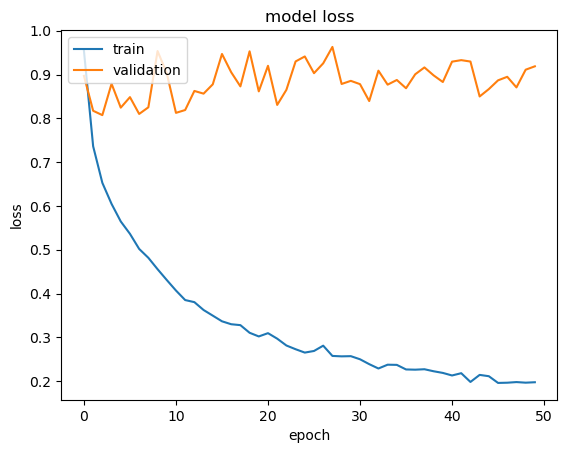

In [10]:
title_model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=2,
    validation_data=(x_val, y_val),
)

plt.plot(title_model.history.history['loss'])
plt.plot(title_model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In the output we can see that we have significate Problems with overfitting. To reduce overfitting in the new model l2 is used and the learning rate is reduced. The learning rate was determined by trial and error. Also an early stopping was added so we don´t get into overfitting.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 6000)              0         
                                                                 
 dense_6 (Dense)             (None, 20)                120020    
                                                                 
 dense_7 (Dense)             (None, 20)                420       
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 21        
                                                                 
Total params: 120,461
Trainable params: 120,461
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
589/589 [===========================

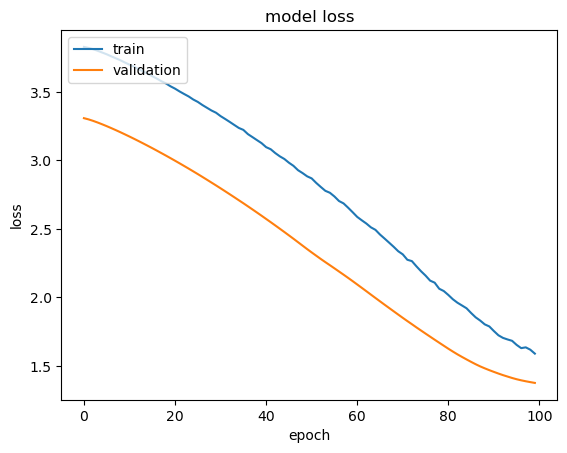

6/6 [==============================] - 0s 2ms/step - loss: 1.5191 - mean_absolute_error: 0.9407
Testset absulut error: 0.940656840801239


In [12]:
title_model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(20,300)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(20, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.Dense(20, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='relu')
])

title_model.summary()

optimizer = tf.keras.optimizers.SGD(learning_rate=0.00001)
loss_fn = tf.keras.losses.MeanAbsoluteError()
sampleID = 100
loss_fn(y_train[sampleID].numpy(), title_model(x_train[sampleID-1:sampleID]).numpy()).numpy()

title_model.compile(optimizer=optimizer,
                    loss=loss_fn,
                    metrics=['mean_absolute_error'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      min_delta=0,
                                      patience=1,
                                      mode='auto'
                                      )
title_model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=2,
    validation_data=(x_val, y_val),
    callbacks=[es]
)

plt.plot(title_model.history.history['loss'])
plt.plot(title_model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

_, validation_acc = title_model.evaluate(x_test, y_test)
print('Testset absulut error:', validation_acc)

The overfitting problem is now better until around epoch 95, but at this point the performance didn´t really improve with changes to the network. Maybe this is due to the small size of the dataset, with only 1686 titles. With this dataset you get in to overfitting really fast and the complexity of the network must be small.
To finish the Project we need a function to evaluate a new title:

In [13]:
def evaluate_a_title(title):

    # Split the words and reform title
    title = title.split()
    title = [nltk.word_tokenize(word) for word in title]
    title_in_vec = []

    # Create the correct input for the network 
    for x in range(0,20):

        if x < len(title):
            title_in_vec.append(list(Word_to_vec_model.wv.get_vector(title[x][0], norm=True)))
        
        else:
            title_in_vec.append([np.float32(0)]*300)
    
    # Return the rating
    return title_model( tf.convert_to_tensor([title_in_vec])).numpy()[0][0]


# Try out the title of our new movie 
print(f"Your title is going to rate: {evaluate_a_title('hello world')} with a toleranze of {str(validation_acc)}, max. rsting is 5")

Your title is going to rate: 2.347484588623047 with a toleranze of 0.940656840801239, max. rsting is 5


Future improvements:
- Train the model on for example the movielens 25m Dataset
- Add the Word2Vec as embedding layer so you are not restricted to the English language 

Conclusion:

The evaluate_a_title() function is as it is not a tool with can be used without understanding the limitations, but you can use it to give you some directions for Netflix movie titles